# Import basis libraries

Before importing the main library we can set the maximum number of threads used by the library and the external libs such as Python and Scipy

In [1]:
from dipole_inverse_tools import set_max_num_threads
set_max_num_threads(6)

In [2]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import dipole_inverse as dpinv

# Using the Dipole class

We first specify the location of the scan data and the tomographic data with the cuboid positions and dimensions.

In [3]:
data_path = Path('./tutorial_qdm_data/')

# location and name of QDM and cuboid file
QDMfile = data_path / 'class_QDM_result2.txt'
cuboidfile = data_path / 'class_cuboid_result2.txt'

# size of QDM domain
QDM_domain = np.array([[300, 1250], [450, 1400]]) * 1e-6
# Spacing between two QDM sample points
QDM_spacing = 1.2e-6
# half length of QDM sensor
QDM_deltax = 0.6e-6
# half width of QDM sensor
QDM_deltay = 0.6e-6
# area of QDM sensor
QDM_area = 1.44e-12
# thickness of sample
sample_height = 80e-6
# distance between QDM and top sample
scan_height = 6e-6
# file to write magnetization grains to
# Magfile = data_path / "grain_mag.txt"

Now we can instantiate the class using the above parameters

In [5]:
mag_svd = dpinv.Dipole(
    QDMfile, cuboidfile, QDM_domain, QDM_spacing,
    QDM_deltax, QDM_deltay, QDM_area, sample_height,
    scan_height)

To compute the magnetization we can use the shortcut fuction `obtain_magnetization` which calls three internal methods in the class. To populate the matrix we choose to use the `cython` method which fills the forward matrix `G` in parallel (much faster). The method to perform the numerical inversion can also be specified, in this case we use `pinv2` from Scipy which uses a Singular Value Decomposition for the pseudo-inverse:

In [6]:
mag_svd.obtain_magnetization(method_populate='cython', method_inverse='scipy_pinv2')

Start inversion with 15876 knowns and 297 unknowns
Inversion has been carried out


In [7]:
# An alternative method is to populate the matrix using the Numba optimised
# function
# mag_svd.obtain_magnetization(method_populate='numba', method_inverse='scipy_pinv2')

In [7]:
# The forward matrix
mag_svd.Forward_G

array([[-5.91133706e-24, -5.96539894e-24,  3.28667825e-23, ...,
        -9.12501315e-25, -4.51911930e-25,  2.02880273e-25],
       [-5.98810471e-24, -6.09712315e-24,  3.32948382e-23, ...,
        -9.34134404e-25, -4.68053201e-25,  1.98776133e-25],
       [-6.06555794e-24, -6.23185697e-24,  3.37283080e-23, ...,
        -9.56233361e-25, -4.84815189e-25,  1.94273624e-25],
       ...,
       [ 1.42618674e-20,  1.76272473e-20, -7.42037749e-21, ...,
         4.95027230e-25,  1.10720805e-24,  1.66493590e-25],
       [ 1.41739838e-20,  1.57806884e-20, -6.02978137e-21, ...,
         5.00082958e-25,  1.08893001e-24,  1.69685846e-25],
       [ 1.38631248e-20,  1.40364639e-20, -4.75211303e-21, ...,
         5.04687376e-25,  1.07061259e-24,  1.72879425e-25]])

We can directly plot the original scan data but in the next section we will use the more powerful plot tools from this library

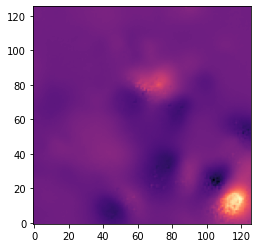

In [9]:
plt.imshow(mag_svd.QDM_matrix, origin='lower', cmap='magma')

This is the field but inverted, we will plot this in the next section using the correct limits

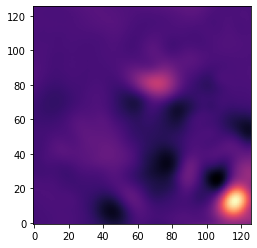

In [10]:
plt.imshow((mag_svd.Forward_G @ mag_svd.Mag).reshape(mag_svd.Ny, -1),
           origin='lower', cmap='magma')

# Plots

The `dipole_inverse` library includes a powerful and modular way of generating plots from the inversion results and the cuboid/grain information.

In [9]:
from dipole_inverse import plot_tools as dpi_pt

We first generate the corresponding arrays in the instance of the Dipole class, in this case we called it `mag_svd`. The `set_grain geometries` will create these arrays with information about the grain position and their dimensions. An useful argument is to scale the space by a factor, in this case we will set everythin in micrometre units:

In [10]:
dpi_pt.set_grain_geometries(mag_svd, spatial_scaling=1e6)

We can, for example, plot the grain boundaries:

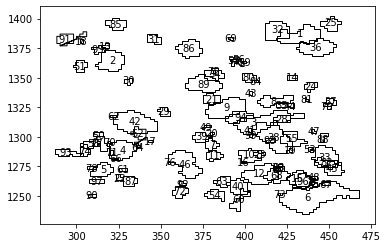

In [11]:
f, ax = plt.subplots()
dpi_pt.plot_grain_boundaries(mag_svd, ax)

But more useful is to combine this information with other plots. For example, we can first pot the grain boundaries and on top of it, we can plot the grains colored by their magnetization, which was computed with the Dipole class methods.
Moreover, we plot the inverted forward field in the background. We can do these operations pasing the same Matplotlib `axis`:

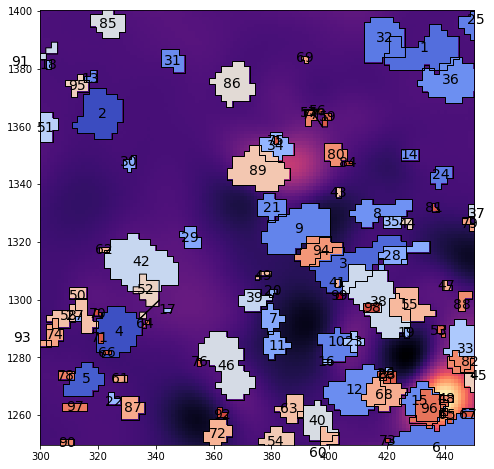

In [12]:
f, ax = plt.subplots(figsize=(8, 8))
dpi_pt.plot_magnetization_on_grains(mag_svd, ax, grain_labels=False)
dpi_pt.plot_grain_boundaries(mag_svd, ax, 
                             labels_args=dict(ha='center', va='center', fontsize=14))
dpi_pt.plot_inversion_field(mag_svd, ax)

In [13]:
# TODO: add method to plot a colorbar